# Learning Objectives

In Empirical Project 1, we mentioned that natural experiments can help us determine whether one variable causes another variable. A useful application of natural experiments is assessing the effects of a policy. To do so, we compare the outcomes of two groups, both before and after the policy took effect:

    The treatment group: those who were affected by the policy
    The control group: those who were not affected by the policy.

Specifically, we take the difference in outcomes of the treatment and control group before the policy was implemented, and compare it with the difference in outcomes after the policy was implemented. This method is known in economics as differences-in-differences⁠. We need to compare outcomes before the policy has happened, because in a natural experiment we cannot choose exactly who receives the treatment (whereas in the lab we could randomly assign the treatment). Since the two groups are not randomly chosen, we need to account for any pre-existing differences between the two groups that could affect the outcomes, for example differences in age (for people) or characteristics (for products). If these other factors remain constant over the period considered, then we can reasonably conclude that any observed changes in the outcome differences between the groups are due to the policy. Natural experiments therefore allow us to make causal statements about policies and outcomes.

We will use the 2014 sugar tax in the US to learn how before-and-after comparisons are done in practice. Sugar-sweetened beverages (SSBs) are considered unhealthy because of their link to conditions such as diabetes and obesity. In November 2014, the city of Berkeley in California became the first US jurisdiction to implement a tax on SSB distributors, with the aim of discouraging SSB consumption. The tax of one cent per fluid ounce meant that if retailers raised their prices to exactly counter the effects of the tax, a $1 can of soda (12 oz) would now cost $1.12. But did sellers actually respond this way? And what effects did the tax have on shoppers’ expenditure on sugary beverages?

A group of researchers did a differences-in-differences study of the effects of this SSB tax, which you can read about in a Forbes article. Figure 3.1 summarizes the timeline of the tax, and the data that they collected and published in a 2017 PLoS Medicine journal paper. We will make before-and-after comparisons using the data they collected, in order to learn about the effects of the sugar tax.

![Figure 3.1: Timeline of the Berkeley sugar tax and data collection](https://www.core-econ.org/doing-economics/book/images/web/figure-03-01.jpg)

---

# Getting Started With Python

In [59]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pingouin as pg
from lets_plot import *

LetsPlot.setup_html(no_js=True)

---

# Part 3.1 Before-and-after comparisons of retail prices

["S1 Text"](https://tinyco.re/9522240) is from the journal paper's supporting information, which explains how the researchers collected their data.

The sample of stores was selected using the top six stores where participants most frequently shopped, also additional stores were added from random selection within their categories from a list of licensed businesses operating to ensure that the sample included stores of different store types and thus represents the population of stores.

Prices were collected using a systematic, standardized process by trained data collectors to ensure accuracy. The data were collected via tablets and paper forms. The data collected on paper forms was double-entered by a trained assistant into a database, and the results were compared to avoid any mistakes.

One challenge encountered was when stores refused to allow data collectors to record prices. To address this, the researchers assigned a replacement store from the same store type and neighborhood, selected at random, ensuring the sample remained representative and unbiased.


In [60]:
path_to_data = Path("./doing-economics-datasets/Dataset Project 3.xlsx")

var_info = pd.read_excel(path_to_data, sheet_name="Data Dictionary")
data = pd.read_excel(path_to_data, sheet_name="Data")

In [61]:
var_info

,Variable Name,Type,Description
0,price,Num,Purchase Price
1,price_per_oz,Num,Price per ounce
2,price_per_oz_c,Num,Price per ounce cents
3,product_id,Num,Unique product identifier
4,size,Num,Total package size
5,store_id,Num,Unique store identifier
6,store_type,Num,"Store Type: 1(Large Supermarket), 2(Small Supe..."
7,supp,Num,Supplemental(1) or standard(0) item in beverag...
8,taxed,Num,Tax status
9,time,Text,Data collection month and year


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store_id        2175 non-null   int64  
 1   type            2175 non-null   object 
 2   store_type      2175 non-null   int64  
 3   type2           235 non-null    object 
 4   size            2175 non-null   float64
 5   price           2175 non-null   float64
 6   price_per_oz    2175 non-null   float64
 7   price_per_oz_c  2175 non-null   float64
 8   taxed           2175 non-null   int64  
 9   supp            2175 non-null   int64  
 10  time            2175 non-null   object 
 11  product_id      2175 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 204.0+ KB


Some of our variables are categorical, however, they are not stored correctly in the data. For example, the `store_type` variable is stored as a string, but it should be stored as a categorical variable. We will fix this in the next section.

Also we use .cat.rename_categories() to rename the categories of the categorical variables. This is useful when we want to change the names of the categories to something more meaningful or easier to understand.

In [63]:
for col in ["type", "taxed", "supp", "store_id", "store_type", "type2", "product_id"]:
    data[col] = data[col].astype("category")

# rename some of the categories.
data["taxed"] = data["taxed"].cat.rename_categories(["not taxed", "taxed"])

data["supp"] = data["supp"].cat.rename_categories(["standard", "supplemental"])

data["store_type"] = data["store_type"].cat.rename_categories(
    ["Large supermarket", "Small supermarket", "Pharmacy", "Gas station"]
)

In [64]:
data["time"].unique()

array(['DEC2014', 'JUN2015', 'MAR2015'], dtype=object)

By looking at the timeline in Figure above, we can see that the price survy was in March 2016 not in March 2015.

In [65]:
data.loc[data["time"] == "MAR2015", "time"] = "MAR2016"
data["time"] = data["time"].astype("category")

Using nunique() we can see how many unique values there are in a variable. We can also use len(variable.unique()) to get the same result.

In [66]:
print("The number of unique stores are", str(data["store_id"].nunique()))

The number of unique stores are 26


In [67]:
print("The number of unique products are", str(data["product_id"].nunique()))

The number of unique products are 247


We are going to compare `price_per_oz_c` in two treatment groups before and after the tax was implemented. 

treatment group one: large supermarkets (store_type = 1)
treatment group two: pharmacies (strore_type = 3)

But first, we are going to create some freqeuncy tables to see how many observations we have in each group. We use pd.crosstab() to create a frequency table in pandas. This function takes two or more variables and creates a table that shows the frequency of each combination of values in the variables.

In [68]:
freq_table_one = pd.crosstab(data["store_type"], data["time"], margins=True)

freq_table_one

time,DEC2014,JUN2015,MAR2016,All
store_type,,,,
Large supermarket,177,209,158,544
Small supermarket,407,391,327,1125
Pharmacy,87,102,73,262
Gas station,73,96,75,244
All,744,798,633,2175


For each store type, the number of observations in each time period is different. For example, for store type 1 (large supermarkets), the number of observations in December 2014, June 2015, and March 2016 are 177, 209, and 158 respectively. 

In [69]:
freq_table_two = pd.crosstab(data["store_type"], data["taxed"], margins=True)

freq_table_two

taxed,not taxed,taxed,All
store_type,,,
Large supermarket,291,253,544
Small supermarket,542,583,1125
Pharmacy,132,130,262
Gas station,109,135,244
All,1074,1101,2175


In [70]:
freq_table_three = pd.crosstab(data["type"], data["time"], margins=True)

freq_table_three

time,DEC2014,JUN2015,MAR2016,All
type,,,,
ENERGY,56,58,49,163
ENERGY-DIET,49,54,35,138
JUICE,70,64,52,186
JUICE DRINK,19,17,6,42
MILK,63,61,53,177
SODA,239,262,215,716
SODA-DIET,128,174,127,429
SPORT,11,16,12,39
SPORT-DIET,2,2,0,4


SODA-DIET has the highest number of observations, on the other hand, WATER-SWEET has the lowest number of observations. Differences in observation counts among product types can stem from several factors. Products with higher popularity or customer demand typically have more observations, as they are purchased or used more frequently.

In [71]:
freq_table_four = pd.crosstab(data["type"], [data["time"], data["taxed"]], margins=True)

freq_table_four

time          DEC2014         JUN2015         MAR2016         All
taxed       not taxed taxed not taxed taxed not taxed taxed      
type                                                             
ENERGY              0    56         0    58         0    49   163
ENERGY-DIET        49     0        54     0        35     0   138
JUICE              70     0        64     0        52     0   186
JUICE DRINK         0    19         0    17         0     6    42
MILK               63     0        61     0        53     0   177
SODA                0   239         0   262         0   215   716
SODA-DIET         128     0       174     0       127     0   429
SPORT               0    11         0    16         0    12    39
SPORT-DIET          2     0         2     0         0     0     4
TEA                 0    52         0    45         0    41   138
TEA-DIET            6     0         6     0         8     0    20
WATER              48     0        38     0        34     0   120
WATER-SWEET         0     1         0     1         0     1     3
All               366   378       399   399       309   324  2175

We are now intrested in comparing the mean price of taxed and untaxed beverages, before and after the tax, we use conditional mean to do this. 
Conditional mean is the mean of a variable, given a condition.

We only want to look at products that were present in all time periods, to ensure that we are comparing the same group of products over time. 

In [72]:
data["period_test"] = (
    data.groupby(["product_id", "store_id"])["time"].transform(lambda x: x.nunique()).fillna(0) == data["time"].nunique()
)

C:\Users\atila\AppData\Local\Temp\ipykernel_5912\1841613573.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["product_id", "store_id"])["time"].transform(lambda x: x.nunique()).fillna(0) == data["time"].nunique()


In [73]:
data_c = data.loc[data["period_test"] & (data["supp"] == "standard")]

data_c.head()

,store_id,type,store_type,type2,size,price,price_per_oz,price_per_oz_c,taxed,supp,time,product_id,period_test
0,16,WATER,Small supermarket,NaN,33.8,1.69,0.050000,5.000000,not taxed,standard,DEC2014,29,True
3,16,WATER,Small supermarket,NaN,33.8,1.69,0.050000,5.000000,not taxed,standard,DEC2014,38,True
5,16,MILK,Small supermarket,LOW FAT MILK,64.0,2.79,0.043594,4.359375,not taxed,standard,DEC2014,41,True
7,16,MILK,Small supermarket,WHOLE MILK,64.0,2.79,0.043594,4.359375,not taxed,standard,DEC2014,43,True
10,16,SODA,Small supermarket,NaN,20.0,1.89,0.094500,9.450000,taxed,standard,DEC2014,59,True


Up until here we used a technique called method chaining, which allows us to apply multiple methods to a DataFrame in a single line of code. This is useful for making our code more concise and readable.

In [74]:
table_res = (
    data_c.groupby(["taxed", "store_type", "time"])
    .agg(avg_price = ("price_per_oz", "mean"), n = ("price_per_oz", "count"))
    .reset_index()
    .pivot(index=["taxed", "store_type", "n"], columns = "time", values = "avg_price")
)

table_res

C:\Users\atila\AppData\Local\Temp\ipykernel_5912\3352716081.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_c.groupby(["taxed", "store_type", "time"])


time                              DEC2014   JUN2015   MAR2016
taxed     store_type        n                                
not taxed Large supermarket 36   0.111920  0.114804  0.117015
          Small supermarket 70   0.136708  0.138165  0.133672
          Pharmacy          18   0.151958  0.160754  0.154353
          Gas station       12   0.169351  0.169641  0.170414
taxed     Large supermarket 36   0.156174  0.169297  0.166843
          Small supermarket 101  0.158510  0.159952  0.154925
          Pharmacy          18   0.181818  0.190788  0.186303
          Gas station       22   0.194117  0.203367  0.192376

In [75]:
table_res["d1"] = table_res["JUN2015"] - table_res["DEC2014"]
table_res["d2"] = table_res["MAR2016"] - table_res["DEC2014"]

table_res

time                              DEC2014   JUN2015   MAR2016        d1  \
taxed     store_type        n                                             
not taxed Large supermarket 36   0.111920  0.114804  0.117015  0.002884   
          Small supermarket 70   0.136708  0.138165  0.133672  0.001458   
          Pharmacy          18   0.151958  0.160754  0.154353  0.008796   
          Gas station       12   0.169351  0.169641  0.170414  0.000290   
taxed     Large supermarket 36   0.156174  0.169297  0.166843  0.013122   
          Small supermarket 101  0.158510  0.159952  0.154925  0.001442   
          Pharmacy          18   0.181818  0.190788  0.186303  0.008970   
          Gas station       22   0.194117  0.203367  0.192376  0.009251   

time                                   d2  
taxed     store_type        n              
not taxed Large supermarket 36   0.005096  
          Small supermarket 70  -0.003036  
          Pharmacy          18   0.002395  
          Gas station       12   0.001063  
taxed     Large supermarket 36   0.010669  
          Small supermarket 101 -0.003585  
          Pharmacy          18   0.004485  
          Gas station       22  -0.001740

In [76]:
(
    ggplot(table_res.reset_index(), aes(fill="taxed", y="d1", x="store_type"))
    + geom_bar(stat="identity", position=position_dodge())
    + labs(
        y="Price change (US$/oz)",
        x="Store type",
        title="Average price change from Dec 2014 to Jun 2015",
        fill="Beverages",
    )
)

In [77]:
(
    ggplot(table_res.reset_index(), aes(fill="taxed", y="d2", x="store_type"))
    + geom_bar(stat="identity", position=position_dodge())
    + labs(
        y="Price change (US$/oz)",
        x="Store type",
        title="Average price change from Dec 2014 to Mar 2016",
        fill="Beverages",
    )
)

To assess whether the difference in mean prices before and after the tax could have happened by chance due to the samples chosen (and there are no differences in the population means), we could calculate the p-value. (Here, ‘population means’ refer to the mean prices before/after the tax that we would calculate if we had all prices for all stores in Berkeley.) The authors of the journal article calculate p-values, and use the idea of statistical significance to interpret them. Whenever they get a p-value of less than 5%, they conclude that the assumption of no differences in the population is unlikely to be true: they say that the price difference is statistically significant⁠. If they get a p-value higher than 5%, they say that the difference is not statistically significant, meaning that they think it could be due to chance variation in prices.

Using a particular cutoff level for the p-value, and concluding that a result is only statistically significant if the p-value is below the cutoff, is common in statistical studies, and 5% is often used as the cutoff level. But this approach has been criticized recently by statisticians and social scientists. The main criticisms raised are that any cutoffs are arbitrary. Instead of using a cutoff, we prefer to calculate p-values and use them to assess the strength of the evidence against our assumption that there are no differences in the population means. Whether the statistical evidence is strong enough for us to draw a conclusion about a policy, such as a sugar tax, will always be a matter of judgement.

In [78]:
p_1 = data_c.query(
    "store_type == 'Large supermarket' & taxed == 'taxed' & time == 'DEC2014'"
)["price_per_oz"].reset_index(drop=True)
p_2 = data_c.query(
    "store_type == 'Large supermarket' & taxed == 'taxed' & time == 'JUN2015'"
)["price_per_oz"].reset_index(drop=True)

# Price difference for taxed products in large supermarkets
d_t = p_2 - p_1
d_t.head()

0    0.010000
1    0.010059
2    0.009600
3    0.010000
4    0.010059
Name: price_per_oz, dtype: float64

In [79]:
alt = data_c.loc[
    (data_c["store_type"] == "Large supermarket") & (data_c["taxed"] == "taxed"), :
].pivot(index=["store_id", "product_id"], columns="time", values="price_per_oz")
alt.head()

time                  DEC2014   JUN2015   MAR2016
store_id product_id                              
25       59          0.099500  0.109500  0.109500
         60          0.032396  0.042456  0.042456
         153         0.135200  0.144800  0.144800
         189         0.094500  0.104500  0.109500
         190         0.029438  0.039497  0.039497

In [80]:
p_1_alt, p_2_alt = alt["DEC2014"], alt["JUN2015"]
d_t_alt = p_2_alt - p_1_alt
d_t_alt.head()

store_id  product_id
25        59            0.010000
          60            0.010059
          153           0.009600
          189           0.010000
          190           0.010059
dtype: float64

In [81]:
pg.ttest(p_2, p_1, paired = True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.768132,35,two-sided,0.000032,"[0.01, 0.02]",0.079958,699.454,0.075305


In [82]:
alt_nt = data_c.loc[
    (data_c["store_type"] == "Large supermarket") & (data_c["taxed"] == "not taxed"), :
].pivot(index=["store_id", "product_id"], columns="time", values="price_per_oz")
d_nt_alt = alt_nt["JUN2015"] - alt_nt["DEC2014"]
print(f"Mean difference is {100*d_nt_alt.mean():.2f} cents/oz")
pg.ttest(d_nt_alt, y=0)

Mean difference is 0.29 cents/oz


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.817855,35,two-sided,0.077655,"[-0.0, 0.01]",0.302976,0.788,0.423962


In [83]:
pg.ttest(d_t_alt, d_nt_alt)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.222715,70,two-sided,0.001929,"[0.0, 0.02]",0.759601,17.601,0.888432


Codes above show how to calculate the p-value using the t-test. The t-test is a statistical test that compares the means of two groups to see if they are significantly different from each other. It is used to determine whether the difference in means is due to chance or if it is statistically significant.

---

# Part 3.2 Before-and-after comparisonswith prices in other areas

When looking for any price patterns, it is possible that the observed changes in Berkeley were not solely due to the tax, but instead were also influenced by other events that happened in Berkeley and in neighbouring areas. To investigate whether this is the case, the researchers conducted another differences-in-differences analysis, using a different treatment and control group:

    The treatment group: Beverages in Berkeley
    The control group: Beverages in surrounding areas.

The researchers collected price data from stores in the surrounding areas and compared them with prices in Berkeley. If prices changed in a similar way in nearby areas (which were not subject to the tax), then what we observed in Berkeley may not be primarily a result of the tax. We will be using the data the researchers collected to make our own comparisons.

In [84]:
beverages = pd.read_stata("./doing-economics-datasets/public_use_weighted_prices2.dta")

beverages.head()

,year,quarter,month,location,beverage_group,tax,price,under_report
0,2013.0,1.0,1.0,Berkeley,soda,Non-taxed,4.853399,NaN
1,2013.0,1.0,1.0,Non-Berkeley,soda,Non-taxed,3.510271,NaN
2,2013.0,1.0,1.0,Non-Berkeley,soda,Non-taxed,3.889572,NaN
3,2013.0,1.0,1.0,Berkeley,soda,Taxed,3.682805,NaN
4,2013.0,1.0,1.0,Non-Berkeley,soda,Taxed,3.516437,NaN


In [85]:
beverages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2728 entries, 0 to 2727
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            2728 non-null   float64
 1   quarter         2728 non-null   float64
 2   month           2728 non-null   float64
 3   location        2728 non-null   object 
 4   beverage_group  2728 non-null   object 
 5   tax             2728 non-null   object 
 6   price           2696 non-null   float64
 7   under_report    72 non-null     float64
dtypes: float64(5), object(3)
memory usage: 170.6+ KB


In [86]:
table_test = (
    beverages.groupby(["year", "month", "location", "tax"])["price"]
    .agg("mean")
    .reset_index()
)

table_test

,year,month,location,tax,price
0,2013.0,1.0,Berkeley,Non-taxed,5.722480
1,2013.0,1.0,Berkeley,Taxed,8.692803
2,2013.0,1.0,Non-Berkeley,Non-taxed,5.348640
3,2013.0,1.0,Non-Berkeley,Taxed,7.991574
4,2013.0,2.0,Berkeley,Non-taxed,5.806468
...,...,...,...,...,...
151,2016.0,2.0,Non-Berkeley,Taxed,8.729508
152,2016.0,3.0,Berkeley,Non-taxed,NaN
153,2016.0,3.0,Berkeley,Taxed,NaN
154,2016.0,3.0,Non-Berkeley,Non-taxed,NaN


In [87]:
table_test["date"] = (
    table_test.apply(
        lambda row: pd.to_datetime(
            str(int(row["year"])) + "-" + str(int(row["month"])), format="%Y-%m"
        ),
        axis = 1,
    )

    + pd.offsets.MonthEnd()
)


table_test.head()

,year,month,location,tax,price,date
0,2013.0,1.0,Berkeley,Non-taxed,5.722480,2013-01-31
1,2013.0,1.0,Berkeley,Taxed,8.692803,2013-01-31
2,2013.0,1.0,Non-Berkeley,Non-taxed,5.348640,2013-01-31
3,2013.0,1.0,Non-Berkeley,Taxed,7.991574,2013-01-31
4,2013.0,2.0,Berkeley,Non-taxed,5.806468,2013-02-28


In [88]:
date_one = pd.to_datetime("2015-01-01")
date_two = pd.to_datetime("2015-03-01")

# Rename 'date' as 'Date' for the horizontal axis label 
table_test = table_test.rename(columns={'date': 'Date'})
(
    ggplot(table_test, aes(x="Date", y="price", color="tax", linetype="location"))
    + geom_vline(xintercept=date_one, color="gray")
    + geom_vline(xintercept=date_two, color="gray")
    + geom_line(size=1)
    + geom_text(
        x=date_one - pd.DateOffset(months=3), y=5, label="Pre-tax", color="black"
    )
    + geom_text(
        x=date_two + pd.DateOffset(months=3), y=5, label="Post-tax", color="black"
    )
    + labs(y="Price", color="Tax", linetype="Location")
)

How strong is the evidence that the sugar tax affected prices? According to the journal paper, when comparing the mean Berkeley and non-Berkeley price of sugary beverages after the tax, the p-value is smaller than 0.00001, and it is 0.63 for non-sugary beverages after the tax.

This p-value is very small, which means that the difference in prices between Berkeley and non-Berkeley areas is statistically significant. This suggests that the sugar tax had a significant effect on the prices of sugary beverages in Berkeley.

The aim of the suger tax was to decrease the consumption of sugary beverages, figure below shows the changes in price, sales, consumer spending, and beverage consumption one year after a tax on sugar-sweetened beverages in Berkely, California, US.

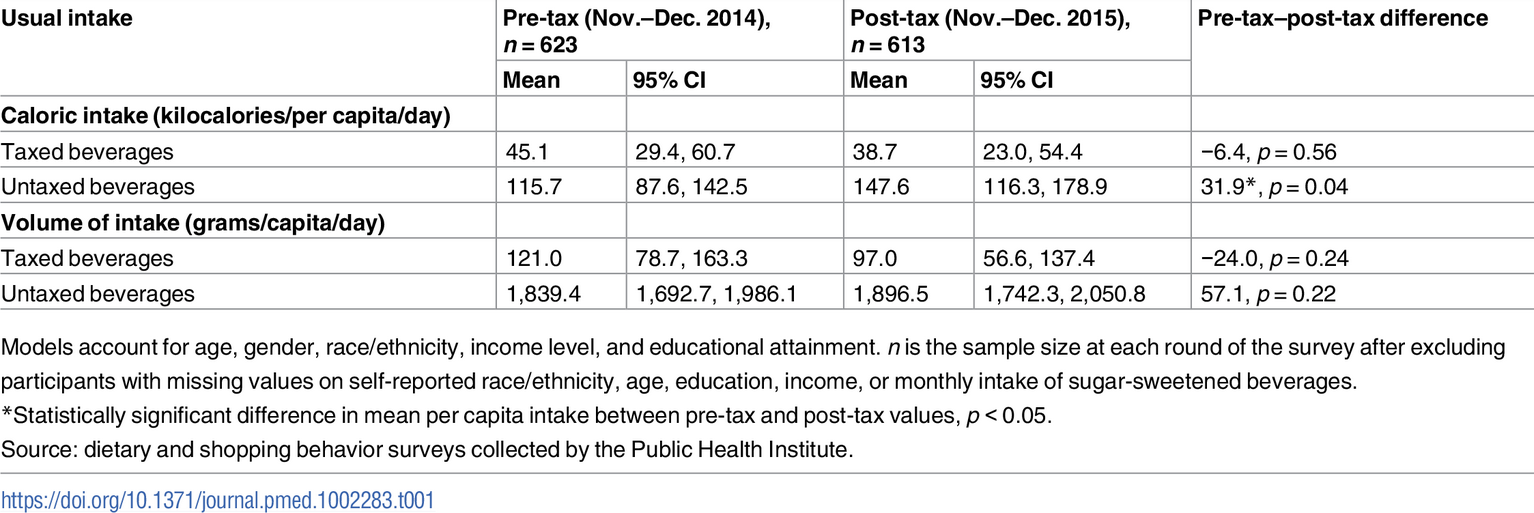

<b>What can we say about the consumption behaviour?</b>

Based on this figure, imposing taxes on sugary beveragews changed the consumption behaviour in Berkley, as we can see the caloric intake (kilocalories/percapita/day) fell by -6.4, and the volume of intake (grams/capita/day) by 24. However, the p-values are quite high and can suggest that the changes in consumption behaviour could be due to chance.

<b>What are the strengths and weaknesses of this study?</b>

The study has several strengths, including a comprehensive understanding of the local context, the inclusion of both large and small stores, and the analysis of a substantial volume of transactions. 

These factors enhance the reliability of the findings regarding the impact of the sugar-sweetened beverage (SSB) tax on prices and sales. However, there are notable limitations. As an observational study, it cannot establish causality between the tax and observed changes, nor does it assess health outcomes. 

The study may be affected by external factors such as media campaigns and educational efforts, which could influence results independently of the tax. The sample underrepresents small and independent stores, and the analysis of consumption is limited by a small effect size and lack of a suitable comparison group. Additionally, scanner data were only available from large supermarket chains, reducing the generalizability of the results. 

Overall, while the study provides valuable insights into the effects of the SSB tax, its findings should be interpreted with caution due to these methodological constraints.

<b>Outline how you would conduct the experiment to ensure that any changes in outcomes (prices, consumption of sugary beverages) are due to the tax and not due to other factors.</b>

While using the natural experiment methodology, our main concern is to identify and control the factors that should remain constant. Therefore, external influences such as media campaigns, educational efforts, and advertisements must be controlled as much as possible.

Additionally, since the sample in this research does not fully represent small and independent stores, I would select the sample using more advanced methods to ensure a higher level of randomness and better coverage.

---